In [1]:
%matplotlib inline
import glob
import pandas as pd
import mne
import matplotlib.pyplot as plt
from io import StringIO
import mne
from mne.io import read_raw_eeglab, read_epochs_eeglab
import numpy as np
from scipy import signal

In [2]:
experiment = 'data/original/sub03/exp01'

In [3]:
# Check if CMAP, MEP and EEG are all available.
cmaps = sorted(glob.glob(experiment + '/cmap/*.xlsx'))
cmap_present = len(cmaps) > 0
meps = sorted(glob.glob(experiment + '/mep/*/*.txt'))
mep_present = len(meps) > 0
eegs = sorted(glob.glob(experiment + '/eeg/*/clean.set'))
eeg_present = len(eegs) > 0
all_present = cmap_present and mep_present and eeg_present
print(all_present)

True


In [4]:
print(eegs)
print(meps)

['data/original/sub03/exp01/eeg/SP 110RMT r1/clean.set']
['data/original/sub03/exp01/mep/SP 110RMT r1/TEP SP x50 at 110 run1.txt', 'data/original/sub03/exp01/mep/SP 110RMT r2/TEP SP x50 at 110 run2.txt', 'data/original/sub03/exp01/mep/SP 110RMT r3/TEP SP x50 at 110 run3.txt']


In [5]:
#%% Read EEG file and prepare epochs in dataframes.
def read_eeg(path):
    epochs = read_epochs_eeglab(path)
    epochs = epochs.pick_channels(ch_names=['Fp1', 'Fpz', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC5', 'FC1', 'FC2', 'FC6', 'M1', 'T7', 'C3', 'Cz', 'C4', 'T8', 'M2', 'CP5', 'CP1', 'CP2', 'CP6', 'P7', 'P3', 'Pz', 'P4', 'P8', 'POz', 'O1', 'O2', 'EOG', 'AF7', 'AF3', 'AF4', 'AF8', 'F5', 'F1', 'F2', 'F6', 'FC3', 'FCz', 'FC4', 'C5', 'C1', 'C2', 'C6', 'CP3', 'CP4', 'P5', 'P1', 'P2', 'P6', 'PO5', 'PO3', 'PO4', 'PO6', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Oz'])
    epoch_list = []
    i = 0
    for epoch in epochs.iter_evoked():
        df = epoch.to_data_frame()
        epoch_list.append(df)
    return epoch_list

In [6]:
#%% Select EEG before TMS.
def crop_epochs(epoch_list, duration_millis=100, sampling_rate=1000):
    new_epoch_list = []
    for epoch_df in epoch_list:
        # Delete EEG after TMS event.
        epoch_df['signal time'] = epoch_df.index
        epoch_df = epoch_df.reset_index()
        indices = epoch_df.index[epoch_df['signal time'] == 0].tolist()
        event_index = int(len(indices)/2)
        delete_count = epoch_df.shape[0] - indices[event_index]
        epoch_df = epoch_df.drop(epoch_df.tail(delete_count).index)

        # Select EEG for the selected duration.
        keep = int(duration_millis * sampling_rate / 1000)
        delete_count = epoch_df.shape[0] - keep
        epoch_df = epoch_df.drop(epoch_df.head(delete_count).index)

        # Append the epoch in the list.
        epoch_df = epoch_df.set_index('signal time')
        new_epoch_list.append(epoch_df)
    return new_epoch_list, -keep

In [7]:
#%% Open MEP file as dataframe.
def open_mep_as_df(path):
    fileMep = open(path, "r+")
    mep_frames = fileMep.read().split('\n\n')
    df_list = []
    for mep_frame in mep_frames:
        df_list.append(pd.read_csv(StringIO(mep_frame), '\t'))
    return df_list

In [8]:
#%% Function to get APB column name.
def get_apb_column_name(mep_frame):
    if 'L APB' in mep_frame:
        return 'L APB'
    else:
        return 'APB'

In [9]:
#%% Function to crop MEP region.
def crop_mep_region(mep_frame):
    crop_start = 0.211
    crop_end = 0.4
    multiplier = 7499 / 1.4998
    start = int(crop_start * multiplier)
    end = int(crop_end * multiplier)
    mep_cropped = mep_frame.iloc[start:end, :]
    time = mep_frame.iloc[start:end, :]
    return mep_cropped, time

In [10]:
#%% Calculate MEP size.
def calculate_mep_size(mep_frame):
    mep_cropped, time = crop_mep_region(mep_frame)
    apb_name = get_apb_column_name(mep_frame)
    max_row = mep_frame.iloc[mep_cropped.idxmax(axis=0)[apb_name]]
    min_row = mep_frame.iloc[mep_cropped.idxmin(axis=0)[apb_name]]
    mep_size = max_row[apb_name] - min_row[apb_name]
    return mep_size

In [11]:
#%% Calculate EEG area.
def calculate_eeg_area(epoch_df):
    gfp = np.sum(epoch_df ** 2, axis=1)
    times = gfp.index
    gfp = mne.baseline.rescale(gfp.values, times, baseline=(None, 0))
    return np.trapz(gfp, times)

In [12]:
#%% Calculate EEG frequency.
def calculate_eeg_frequency(epoch_df):
    avg = epoch_df.mean(axis=1)
    sp = np.fft.fft(avg.values)
    freq = np.fft.fftfreq(avg.shape[0])
    return np.max(np.abs(sp))

In [13]:
def calculate_eeg_max_amplitude(epoch_df):
    avg = epoch_df.mean(axis=1)
    return np.max(avg.values)

In [14]:
def resample_eeg(raw_eeg, sample_rate=2048, current_sample_rate=4096):
    new_list = []
    i = 0
    for epoch_df in raw_eeg:
        old_sig = epoch_df.reset_index().drop(['time'], axis=1)
        sample_count = int(epoch_df.shape[0] * sample_rate / current_sample_rate)
        new_sig = signal.resample(old_sig.values, sample_count)
        new_sig = pd.DataFrame(new_sig)
        new_sig.columns = old_sig.columns
        indices = epoch_df.index.values
        new_sig['time'] = np.linspace(indices[0], indices[indices.shape[0]-1], sample_count, endpoint=False).astype(int)
        new_sig = new_sig.set_index('time')
        new_list.append(new_sig)
    return new_list

In [42]:
epoch_df = x[0]
duration_millis=500
sampling_rate=2048

# Delete EEG after TMS event.
epoch_df['signal time'] = epoch_df.index
epoch_df = epoch_df.reset_index()
indices = epoch_df.index[epoch_df['signal time'] == 0].tolist()
event_index = int(len(indices)/2)
delete_count = epoch_df.shape[0] - indices[event_index]
epoch_df = epoch_df.drop(epoch_df.tail(delete_count).index)

# Select EEG for the selected duration.
keep = int(duration_millis * sampling_rate / 1000)
delete_count = epoch_df.shape[0] - keep
# epoch_df = epoch_df.drop(epoch_df.head(delete_count).index)

# # Append the epoch in the list.
# epoch_df = epoch_df.set_index('signal time')

# plt.plot(epoch_df)
epoch_df.shape[0]

500

In [18]:
#%% Generate relations between EEG parameters and MEP sizes.
def generate_mep_relation(eeg_path, mep_path):
    raw_eeg = read_eeg(eeg_path)
    sampled_eeg = resample_eeg(raw_eeg)
    epoch_list, crop_length = crop_epochs(sampled_eeg, 500)
    mep_frames = open_mep_as_df(mep_path)
    if (len(epoch_list) != len(mep_frames)):
        print('MEP and EEG epoch count did not match')
        return
    points = []
    for i in range(len(epoch_list)):
        mep_size = calculate_mep_size(mep_frames[i])
        eeg_area = calculate_eeg_area(epoch_list[i])
        freq = calculate_eeg_frequency(epoch_list[i])
        max_amplitude = calculate_eeg_max_amplitude(epoch_list[i])
        points.append((eeg_area, freq, max_amplitude, mep_size))
    mep_size_df = pd.DataFrame(points, columns=('area', 'freq', 'max_amplitude', 'mep'))
    return mep_size_df, raw_eeg, crop_length

Extracting parameters from data/original/sub03/exp01/eeg/SP 110RMT r1/clean.set...
50 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Ready.
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.

KeyError: "['signal time'] not found in axis"

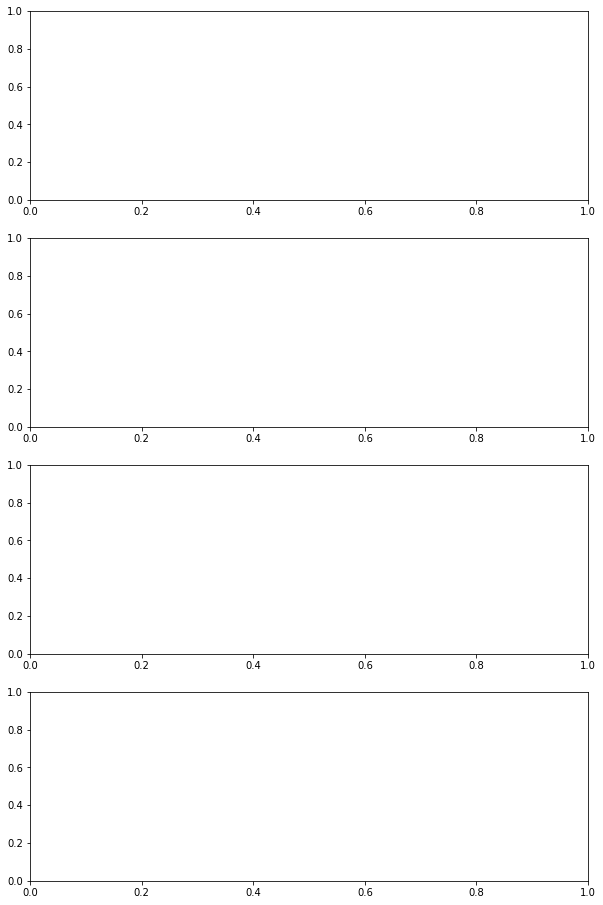

In [19]:
#%% Loop through all the EEGs and MEPs.
for eeg_path in eegs:
    eeg_take = eeg_path.split('/')[5]
    for mep_path in meps:
        if (mep_path.split('/')[5] == eeg_take):
            mep_size_df, raw_eeg, crop_length = generate_mep_relation(eeg_path, mep_path)
            fig, axs = plt.subplots(4, 1, figsize=(10, 16))
            for eeg in raw_eeg:
                axs[0].plot(eeg.index.values, eeg.reset_index().drop(['signal time', 'time'], axis=1))
            axs[0].set_title('Clean EEG')
            axs[0].set(xlabel='Time (ms)', ylabel='mV')
            axs[0].axvspan(crop_length, 0, facecolor="b", alpha=0.1)
            axs[1].plot(mep_size_df.area, mep_size_df.mep, 'o')
            axs[1].set_title('MEP Size vs Area Under Curve')
            axs[1].set(xlabel='Area', ylabel='MEP Size')
            axs[2].plot(mep_size_df.freq, mep_size_df.mep, 'o')
            axs[2].set_title('MEP Size vs Dominant Frequency')
            axs[2].set(xlabel='Dominant Frequency', ylabel='MEP Size')
            axs[3].plot(mep_size_df.max_amplitude, mep_size_df.mep, 'o')
            axs[3].set_title('MEP Size vs Max EEG amplitude')
            axs[3].set(xlabel='Max Amplitude', ylabel='MEP Size')
            fig.suptitle(eeg_path.split('/')[2] + '/' + eeg_path.split('/')[3] + '/' + eeg_path.split('/')[4] + '/' + eeg_path.split('/')[5])
            plt.tight_layout()

In [ ]:
#%% Calculate EEG frequency.
def calculate_fft(epoch_df):
    avg = epoch_df.mean(axis=1)
    sp = np.fft.fft(avg.values)
    freq = np.fft.fftfreq(1000, 0.001)
    return sp, freq

In [ ]:
#%% Loop through all the EEGs and MEPs.
for eeg_path in eegs:
    eeg_take = eeg_path.split('/')[5]
    for mep_path in meps:
        if (mep_path.split('/')[5] == eeg_take):
            raw_eeg = read_eeg(eeg_path)
            epoch_list, crop_length = crop_epochs(raw_eeg, 500)
            plt.figure(figsize=(12,4))
            for i in range(len(epoch_list)):
                sp, freq = calculate_fft(epoch_list[i])
                plt.plot(freq[1:40], np.abs(sp[0:39]))
                plt.xlabel('Frequency (Hz)')
                plt.ylabel('Power')
                plt.tight_layout()